In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [31]:
def get_stdv_from_files(files, truth=None):

    data = [np.load(file) for file in files]
    
    # Initialize a dictionary to hold lists of y-values for each x-value index
    y_values_per_x_index = {}
    ratio_values_per_x_index = {}
    x_values = np.load(files[0])[0]  # Load the x-values from the first file


    for single_file_data in data:
        for i, y in enumerate(single_file_data[1]):  # single_file_data[1] are the y-values
            if i not in y_values_per_x_index:
                y_values_per_x_index[i] = []
            y_values_per_x_index[i].append(y)        
    
        for i, r in enumerate(single_file_data[2]):  # single_file_data[1] are the y-values
            if i not in ratio_values_per_x_index:
                ratio_values_per_x_index[i] = []
            ratio_values_per_x_index[i].append(r)

    mean = [np.mean(y_values) for y_values in y_values_per_x_index.values()]
    # print(f"mean: {mean}")        
    if truth is None: #Standard Deviation, using Means
        std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]
        ratio_std_devs = [np.std(y_values) for y_values in ratio_values_per_x_index.values()]
        

    else: #MSE, from truth. Usually Djanhog in the closure studies
        std_devs = [np.mean([(y - truth[1][i]) ** 2 for y in y_values])/np.mean(truth[1][i]) for i, y_values in y_values_per_x_index.items()]
        ratio_std_devs = [np.mean([(y - truth[2][i]) ** 2 for y in y_values]) for i, y_values in ratio_values_per_x_index.items()]
        
        #ratio_std_devs = [np.mean([(y - truth[2][i]) ** 2 for y in y_values]) for i, y_values in ratio_values_per_x_index.items()]

    return x_values, std_devs, ratio_std_devs, mean

In [117]:
def plot_feature(feature, xlabel, title, unit):
    ## first get baseline rapgap and djangoh
    fig = plt.figure(figsize=(20, 5))
    outer_gs = gridspec.GridSpec(1, 3, figure=fig, hspace=0.3, wspace=0.2) #1 row, 3 cols, with padding

    alpha = 0.8
    label_size = 16
    E_Max = 5

    rapgap = np.load(f'../plots/Rapgap_unfolded0_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens0_plot_vals.npy')
    djangoh = np.load(f'../plots/Djangoh_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens0_plot_vals.npy')

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer_gs[0], height_ratios=[3, 1], hspace=0.05
    )
    ax1_top = fig.add_subplot(inner_gs[0])
    ax1_bottom = fig.add_subplot(inner_gs[1], sharex=ax1_top)
    r_scatter = ax1_top.scatter(
        rapgap[0], rapgap[1],
        marker='_', label='Rapgap',
        alpha=alpha, s=100, color='k'
    )
    print(f"rapgap[1]: {rapgap[1]}")
    d_scatter = ax1_top.fill_between(
        djangoh[0], djangoh[1],
        step='mid', color='gray',
        alpha=0.3, label='Djangoh'
    )

    ax1_top.set_title(f'{title}', fontsize=20)
    ax1_top.set_ylabel('Normalized Counts', fontsize=label_size)
    ax1_top.tick_params(axis='both', which='major', labelsize=12)
    # Remove x-axis tick marks and labels on the top subplot
    ax1_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax1_top.grid(True)

    # --- Bottom Subplot: Ratio Plot ---
    ax1_bottom.set_ylabel(r'Ratio', fontsize=label_size)
    ax1_bottom.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
    ax1_bottom.set_ylim(0.5, 1.5)
    ax1_bottom.tick_params(axis='both', which='major', labelsize=12)
    ax1_bottom.grid(True)


    y_vals_par = []
            
    y_vals_avg, ratio_avg = 0,0
    for n in range(50):
        step_file = f'../plots/Rapgap_unfolded{n}_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens{n}_plot_vals.npy'
        # print(step_file)
        
        if not os.path.exists(step_file):
            print(f"Skipping missing file: {step_file}")
            continue

        step_data = np.load(step_file)

        step_shift = max(step_data[0]) / len(step_data[0]) / 10 / (n + 1)

        y_vals_par.append(step_data[1])
        y_vals_avg += step_data[1]
        ratio_avg += step_data[2]


    median_file = f'../plots/Rapgap_unfoldedMedian_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ensMedian_plot_vals.npy'
    median_data = np.load(median_file)
    y_vals_median = median_data[1]

    truncmean_file = f'../plots/Rapgap_unfoldedTruncMean_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ensTruncMean_plot_vals.npy'
    truncmean_data = np.load(truncmean_file)
    y_vals_truncmean = truncmean_data[1]

    # truncmean_file = 
    # print(f"mean: {y_vals_avg/10}")
    print(f"median: {y_vals_median}")
    print(f"truncmean: {y_vals_truncmean}")

    ax1_top.scatter(step_data[0], y_vals_avg/50, marker='o',label=f"Mean", color='blue', facecolors='none')    
    ax1_top.scatter(step_data[0], y_vals_median, marker='*',label=f"Median", color='green', facecolors='none')    
    ax1_top.scatter(step_data[0], y_vals_truncmean, marker='v',label=f"Truncated Mean", color='red', facecolors='none')    

    ax1_top.set_ylim(0, 1.5*np.max(y_vals_truncmean))



    # Add the ratio data to the bottom subplot
    ax1_bottom.scatter(
        rapgap[0], rapgap[1]/djangoh[1],
        marker='_', alpha=alpha, color='k'
    )

    # Add the ratio data to the bottom subplot
    ax1_bottom.scatter(
        rapgap[0], y_vals_avg/(50*djangoh[1]),
        marker='o', alpha=alpha, color='blue', facecolors='none'
    )

    ax1_bottom.scatter(
        rapgap[0], y_vals_median/(djangoh[1]),
        marker='*', alpha=alpha, color='green', facecolors='none'
    )

    ax1_bottom.scatter(
        rapgap[0], y_vals_truncmean/(djangoh[1]),
        marker='v', alpha=alpha, color='red', facecolors='none'
    )


    # print(y_vals_avg/(10*djangoh[1]))
    ax1_bottom.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)  # Reference line at ratio=1

    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [0, 1, 2, 3, 4]

    # ax1_top.legend(handles, labels, loc="upper right", ncol=2, columnspacing=1.5, handletextpad=0.5,)

    ax1_top.legend(fontsize=12, loc='upper right',ncol=2, columnspacing=1.5, handletextpad=0.5)







rapgap[1]: [0.10242131 0.03152066 0.00566953 0.00089604 0.00012438]
median: [0.103198   0.03128538 0.00556262 0.00086822 0.0001205 ]
truncmean: [0.10311379 0.0313284  0.00556662 0.00086961 0.00012056]
rapgap[1]: [0.21686574 0.53424381 0.65175851 0.36891245 0.15920471 0.06901478]
median: [0.22041808 0.53574402 0.650913   0.36736294 0.15814635 0.06741562]
truncmean: [0.22005303 0.5351647  0.65020296 0.36781228 0.15879417 0.06797285]
rapgap[1]: [3.93008885 1.2970759  0.70974375 0.44998599 0.29123638 0.19741771
 0.12445141]
median: [3.97725509 1.28582007 0.69979108 0.44116147 0.28450166 0.19093756
 0.12053307]
truncmean: [3.96973605 1.28839021 0.70059133 0.44221793 0.28562903 0.19206768
 0.12136777]
rapgap[1]: [3.45283768 4.35635773 4.36211411 3.1004047  1.70763454 0.81253635
 0.22171904]
median: [3.4701183  4.40133148 4.42696902 3.13092297 1.69395718 0.80391232
 0.21893697]
truncmean: [3.44996917 4.37674082 4.40889979 3.1247331  1.69517126 0.80729755
 0.22032405]
rapgap[1]: [0.19738676 0.

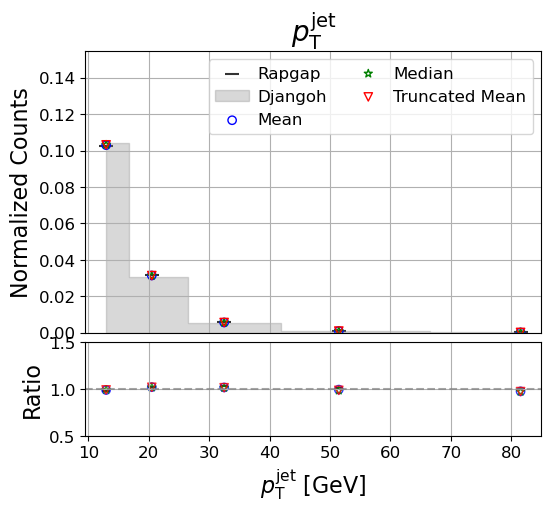

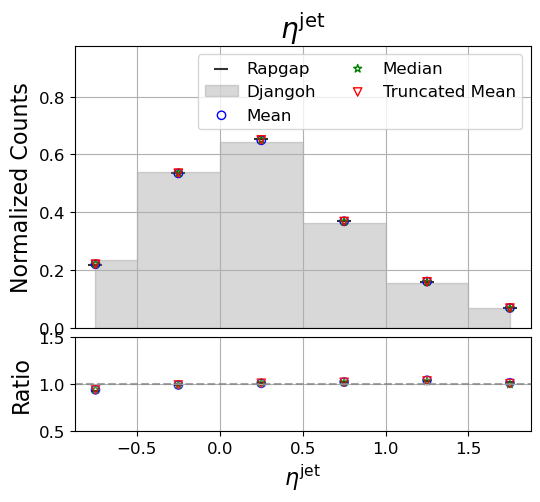

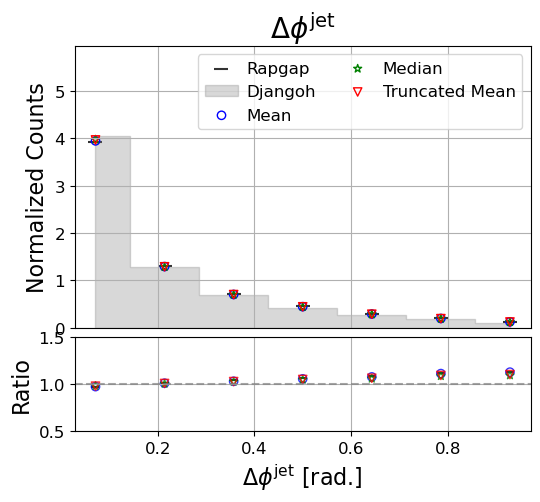

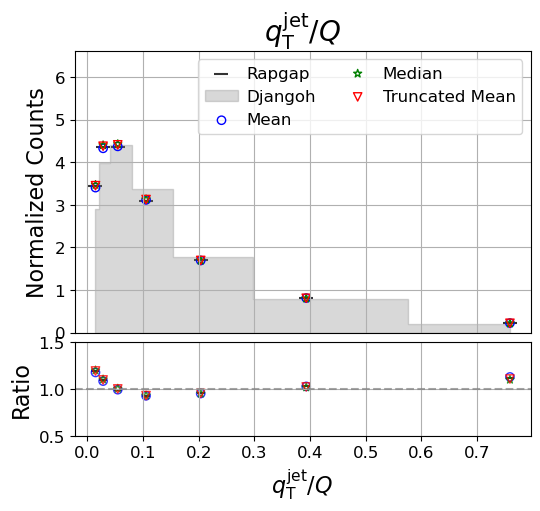

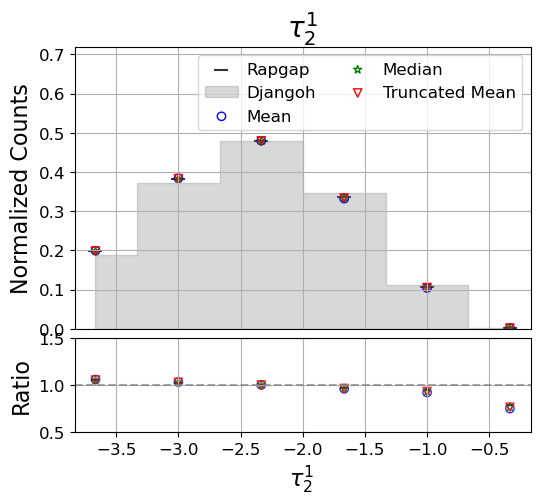

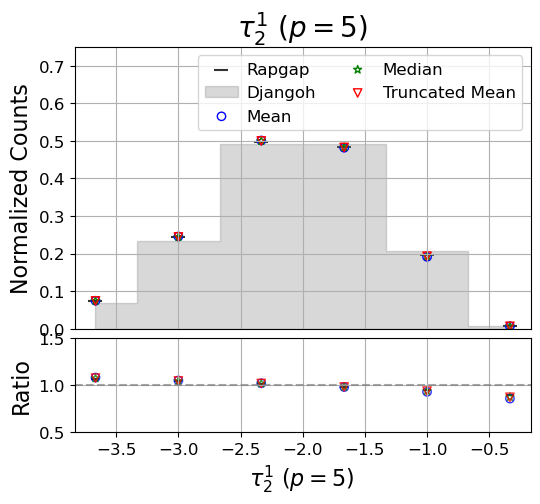

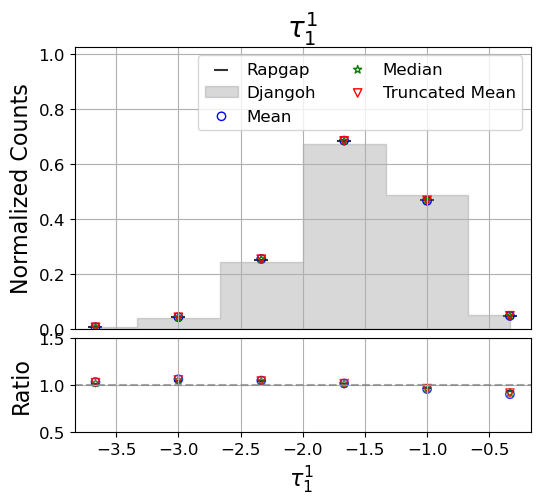

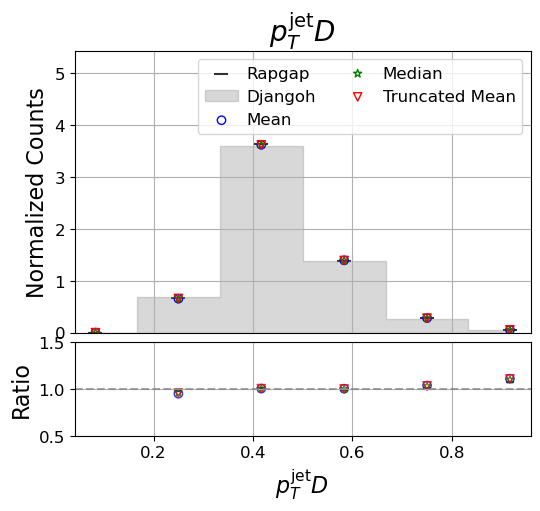

In [118]:
jet_features = ['jet_pT', 'jet_eta', 'jet_phi', 'jet_qT', 'jet_tau12', 'jet_tau11p5', 'jet_tau11', 'jet_ptD']
jet_labels = [r'$p_\mathrm{T}^\mathrm{jet}$',r'$\eta^\mathrm{jet}$',
              r'$\Delta\phi^\mathrm{jet}$',r'$q_\mathrm{T}^\mathrm{jet}/Q$', 
              r'$\tau^1_2$', r'$\tau^1_2\ (p=5)$', r'$\tau^1_1$', '$p^\mathrm{jet}_{T}D$']
units = ['[GeV]','','[rad.]','','','','','']
for jet_feature, jet_label, unit in zip(jet_features, jet_labels, units):
    plot_feature(jet_feature, jet_label, jet_label, unit)

rapgap[1]: [1.06439508 1.08905872 1.04658774 0.9681912  0.90484036 0.82574021
 0.76265375 0.70020139 0.63973427 0.58789618 0.53778014 0.48497804
 0.44305411 0.40263037 0.36421736 0.32434965 0.29879946 0.26273418
 0.2476969  0.2227622  0.20423501 0.18791755 0.17214772 0.16053329
 0.14846101 0.13292628 0.12528914 0.11371279 0.10382336 0.09478123
 0.08569458 0.07679379 0.06831701 0.06064187 0.05573231 0.04917659
 0.04599484 0.04110371 0.03448674 0.03280206 0.02764208 0.02523615
 0.02237801 0.02352407 0.02043621 0.01942803 0.01812409 0.01714544
 0.01461078]
median: [1.07684993 1.10196384 1.05780764 0.97529814 0.91007098 0.83022333
 0.76342697 0.70220642 0.63913438 0.58735887 0.53629165 0.48441524
 0.44191198 0.40089688 0.36294148 0.32330603 0.29780135 0.26131216
 0.24594437 0.22111304 0.20260148 0.18582755 0.17008245 0.15830835
 0.14659542 0.13046745 0.12305324 0.11186507 0.10163615 0.0925479
 0.08368497 0.07492673 0.06669181 0.05912339 0.05438154 0.04814601
 0.04469005 0.03955735 0.033414

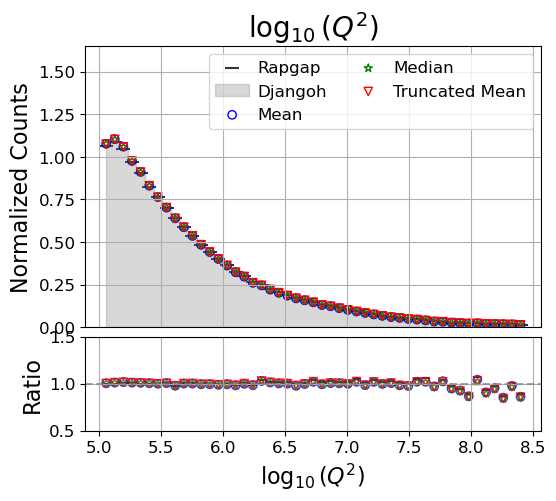

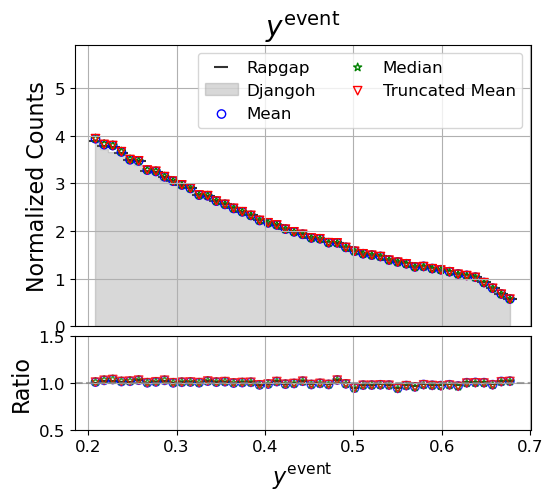

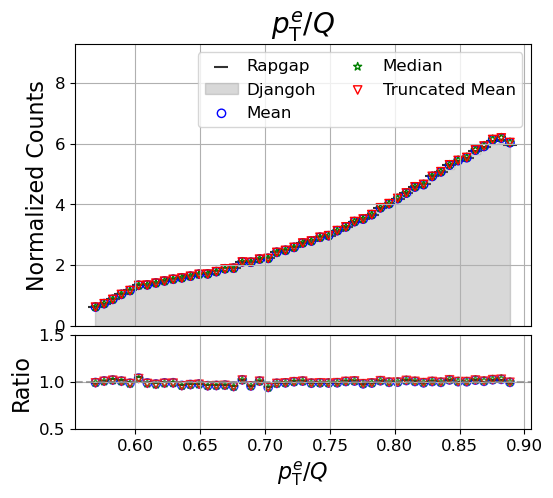

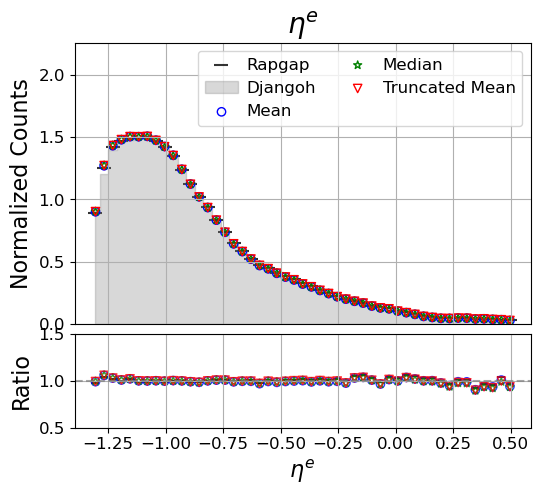

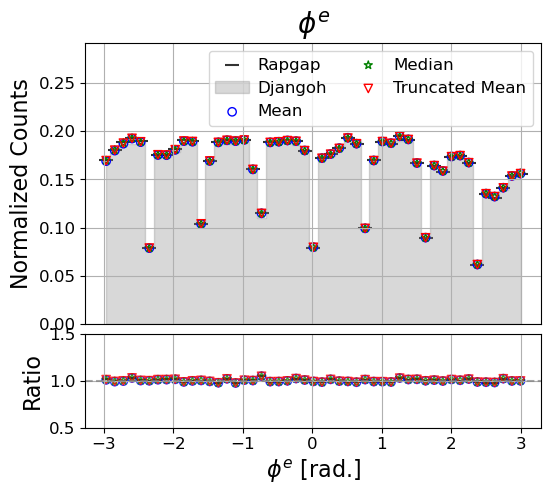

In [120]:
event_labels = [r'$\log_{10}(Q^2)$',r'$y^\mathrm{event}$',r'$p_\mathrm{T}^e/Q$',r'$\eta^e$',r'$\phi^e$']
event_features = [f"event{e}" for e in range(len(event_labels))]
units = ["", "", "", "", "[rad.]"]

for event_feature, event_label, unit in zip(event_features, event_labels, units):
    plot_feature(event_feature,  event_label, event_label, unit)
    print()

rapgap[1]: [0.04344207 0.05893806 0.07507054 0.09140656 0.10696214 0.12347638
 0.13927434 0.15569025 0.17286095 0.1904873  0.2093479  0.22894888
 0.24814053 0.26670982 0.284492   0.30231058 0.31879932 0.33384794
 0.34634314 0.35740866 0.36177819 0.35850248 0.34778259 0.3295172
 0.31292446 0.29958916 0.2881264  0.27994527 0.27254942 0.26497854
 0.2597912  0.25667537 0.25097831 0.24607217 0.24324124 0.24033261
 0.23641613 0.23206965 0.2298652  0.22452667 0.21959782 0.21275655
 0.20511573 0.19660992 0.18659418 0.17370995 0.15838328 0.13818835
 0.11354352]
median: [0.04319926 0.05868466 0.07485497 0.09134455 0.10692349 0.12353076
 0.13933795 0.15585349 0.17299205 0.19052851 0.20940741 0.22894475
 0.24796451 0.26639787 0.28403811 0.30193594 0.31848633 0.33345764
 0.34609304 0.35729318 0.36172179 0.35849349 0.34756882 0.32899807
 0.31215871 0.29870868 0.2872023  0.2790964  0.27158805 0.26399052
 0.25883973 0.25587167 0.25018771 0.24547681 0.24266149 0.23992079
 0.23611289 0.23201236 0.229919

/tmp/ipykernel_33788/456801495.py:97: RuntimeWarning: invalid value encountered in divide
  rapgap[0], rapgap[1]/djangoh[1],
/tmp/ipykernel_33788/456801495.py:103: RuntimeWarning: invalid value encountered in divide
  rapgap[0], y_vals_avg/(50*djangoh[1]),
/tmp/ipykernel_33788/456801495.py:108: RuntimeWarning: invalid value encountered in divide
  rapgap[0], y_vals_median/(djangoh[1]),
/tmp/ipykernel_33788/456801495.py:113: RuntimeWarning: invalid value encountered in divide
  rapgap[0], y_vals_truncmean/(djangoh[1]),


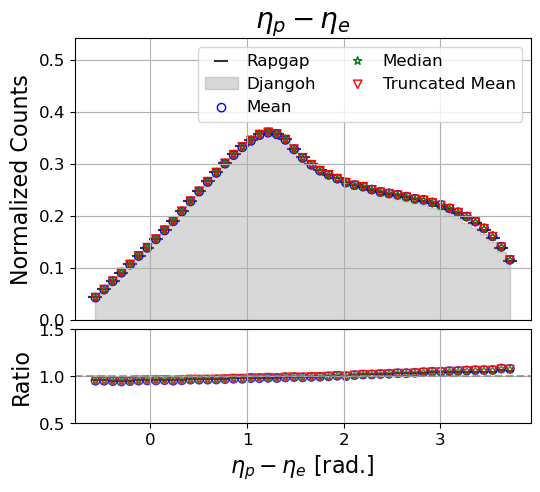

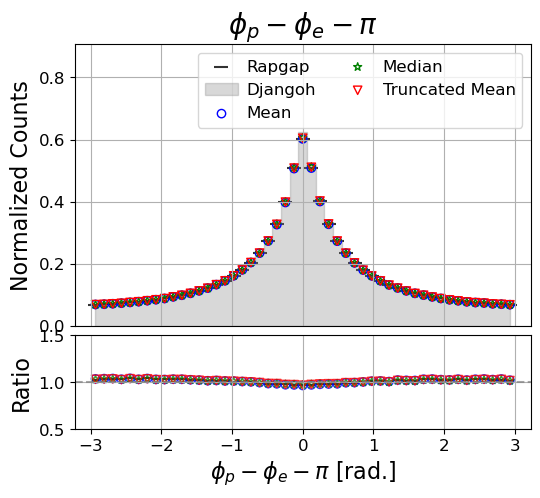

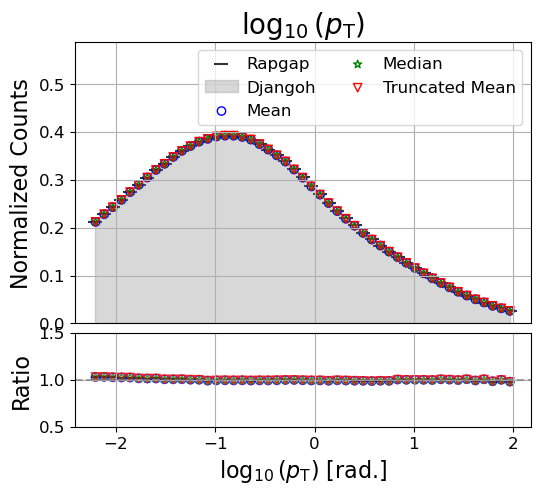

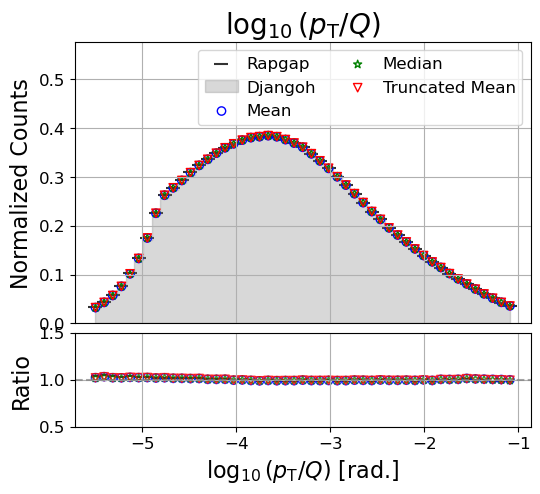

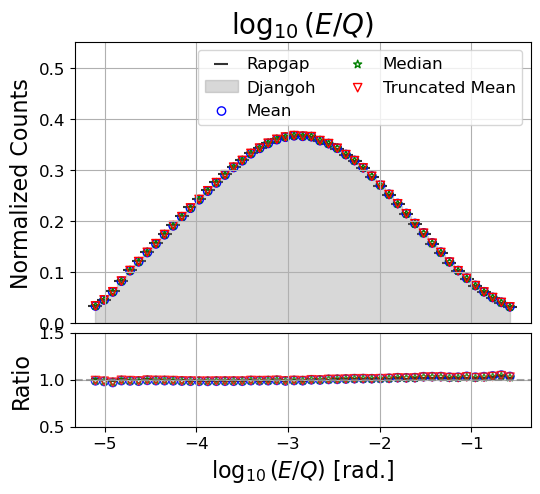

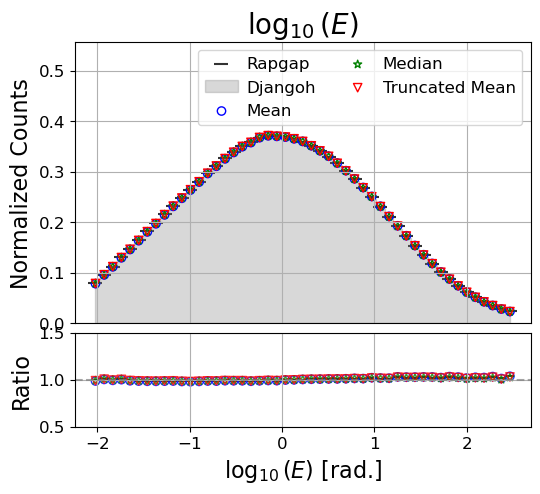

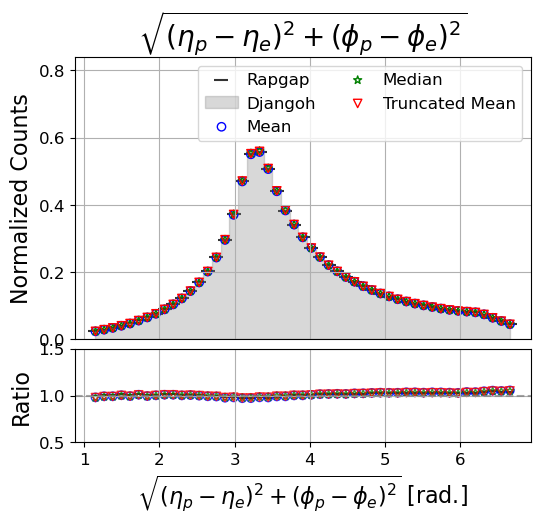

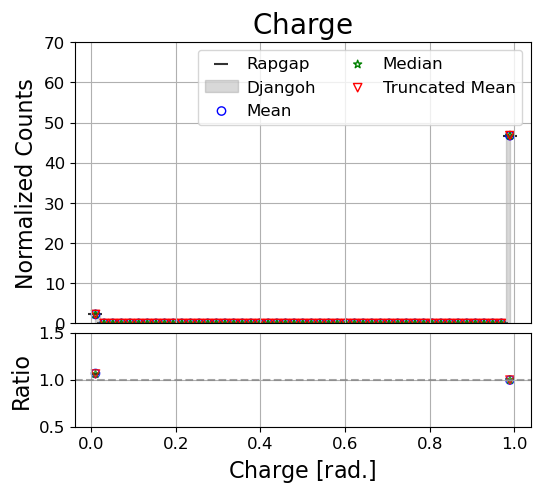

In [121]:
particle_labels = [
    '$\eta_p - \eta_e$',
    '$\phi_p-\phi_e-\pi$',
    '$\log_{10}(p_\mathrm{T})$',
    '$\log_{10}(p_\mathrm{T}/Q)$',
    '$\log_{10}(E/Q)$',
    '$\log_{10}(E)$',
    '$\sqrt{(\eta_p-\eta_e)^2+(\phi_p-\phi_e)^2}$',
    '$\mathrm{Charge}$']

particle_features = [f'particle{p}' for p in range(len(particle_labels))]

for particle_feature, particle_label in zip(particle_features, particle_labels):
    plot_feature(particle_feature, particle_label, particle_label, unit)
    print()